# **Importing the required modules**

In [2]:
#importing required libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import zipfile
import warnings
import numpy as np
from google.colab import drive
from glob import glob
import matplotlib.pyplot as plt

# **Ignoring the warning messages**

In [3]:
#Ignoring the warnings 
warnings.filterwarnings('ignore')

# **Mounting the google drive**

In [4]:
#Connecting to the google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Fetching an image from machine and checking few transormations on it**

In [5]:
#importing an image from the data set and pre-processing it to verifying transformations performed on it before performing it on the whole data set.
#In this cell, fetching an image from the data set and resizing it.
import cv2
width, height= 224, 224
img = cv2.imread('/content/drive/MyDrive/Data Directory/Train/Jeans_Men/Jeans0.jpg')
img_resized = cv2.resize(img,(width, height))

In [6]:
#Checking the shape of the resized image
img_resized.shape

(224, 224, 3)

(320, 130, 3)


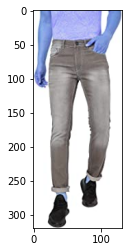

In [7]:
#Shape of original image
#plotting the original image 
print(img.shape)
plt.imshow(img)

It is observed that the image fetched is in the form of a BGR image and not in the form of RGB image. This is because we are using cv2 to import images for further processing.

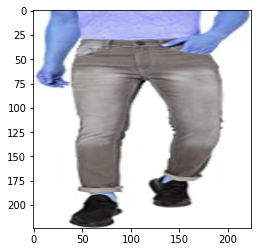

In [8]:
#plotting resized image
plt.imshow(img_resized)

# **Color Conversion of selected image from BGR to RGB**

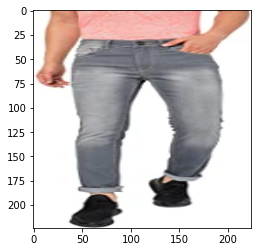

In [9]:
#Changing color from BGR to RGB to view the original color of the resized image
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

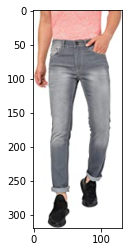

In [10]:
#Changing color from BGR to RGB to view the real color combinations of the original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# **Image Pre-processing & Resizing using Data Generator**

In [11]:
#Use of ImageDataGenerator for performing data augmentation and storing it into a variable and applying the same on the train data set during the training period.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [12]:
#Use of ImageDataGenerator for performing data augmentation and storing it into a variable and applying the same on the test data set while testing data.
test_datagen = ImageDataGenerator(rescale = 1./255)

# **Fetching Train and Test Data**

In [13]:
#Fetching train data from the drive using it's path and resizing all of them, also passing images with batch size 32 to avoid data overloading.
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Data Directory/Train',
                                                 target_size = (width, height),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 874 images belonging to 3 classes.


In [14]:
#Fetching test data from the drive using it's path and applying transformations on them to decrease it's size, also passing images with batch size 5 to avoid data overloading.
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Data Directory/Test',
                                            target_size = (width, height),
                                            batch_size = 5,
                                            class_mode = 'categorical')

Found 36 images belonging to 3 classes.


# **Model Buiding**

In [20]:
#Creating variable to store the size of the new images that we will pass to the model
IMAGE_SIZE = [224, 224]


# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
# useful for getting number of classes
folders = glob('/content/drive/MyDrive/Data Directory/Train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(150, activation='relu')(x)
prediction = Dense(len(folders),activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
folders

['/content/drive/MyDrive/Data Directory/Train/Trousers_Men',
 '/content/drive/MyDrive/Data Directory/Train/Sarees',
 '/content/drive/MyDrive/Data Directory/Train/Jeans_Men']

# New Section

In [21]:
# fit the model
r = model.fit_generator( training_set,validation_data=test_set,epochs=2)

Epoch 1/2
28/28 [==============================] - 339s 12s/step - loss: 1.4984 - accuracy: 0.6911 - val_loss: 0.1521 - val_accuracy: 0.9444
Epoch 2/2
28/28 [==============================] - 339s 12s/step - loss: 0.1981 - accuracy: 0.9153 - val_loss: 0.0918 - val_accuracy: 0.9722


In [27]:
#History of accuracies performed per epoch
r.history

{'accuracy': [0.6910755038261414, 0.9153317809104919],
 'loss': [1.4984207153320312, 0.19814758002758026],
 'val_accuracy': [0.9444444179534912, 0.9722222089767456],
 'val_loss': [0.152072936296463, 0.0918121188879013]}

In [30]:
def plot_metric(r, metric):
    train_metrics = r.history[metric]
    val_metrics = r.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

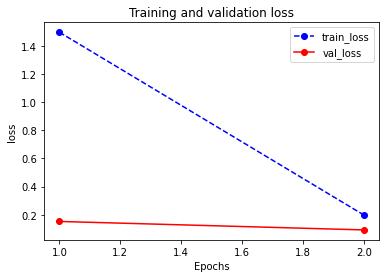

In [31]:
plot_metric(r, 'loss')

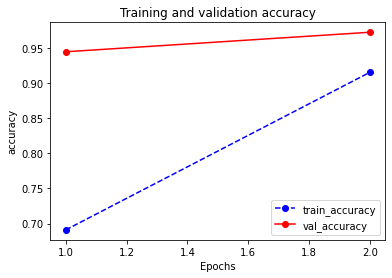

In [32]:
plot_metric(r, 'accuracy')

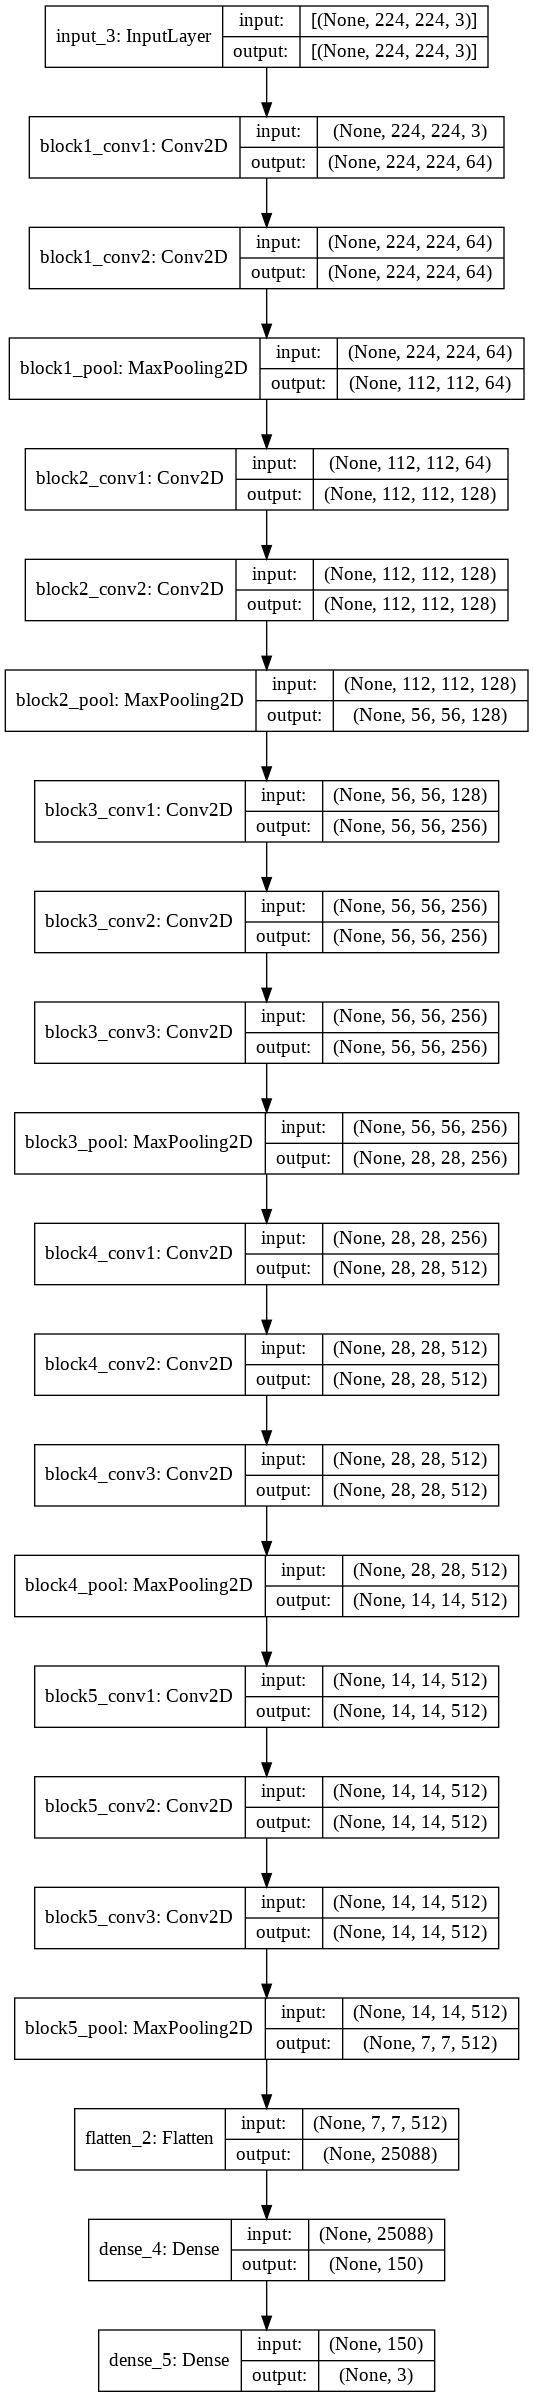

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)